In [1]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt

# More Work with Time Series

It is common in working with earth or ocean systems to encounter observational datasets that have been regularly sampled in time.  These are time series datasets and are common tools for making familiar observations such as temperature (often represented in hourly, daily, montly-averages or annual-averages), wave heights (may be sampled hourly or once a second, 1 Hz) or stream flow, earthquake obserations (seismograms are ususally sampled hundreds or thousands of times per second).  There are entire courses (even at WWU) about how to work with timeseries data. Here we'll spend a bit of time working more with the `datetime` class in Python, which makes working with timeseries date much easier.  We'll also play with a bit of spectral analysis for fun (see [This math-free primer on Fourier Analysis from Jezzamon](https://www.jezzamon.com/fourier/index.html)) that we can use to decompose a time series into it's periodic contributions.

First a bit of background - 
According to Wikipedia:
> A time series is a series of data points indexed (or listed or graphed) in time order. Most commonly, a time series is a sequence taken at successive equally spaced points in time. Thus it is a sequence of discrete-time data. Examples of time series are heights of ocean tides, counts of sunspots, and the daily closing value of the Dow Jones Industrial Average.

Pandas and Python in general have some great tools to work with discretely sampled time series.  These can be read about by referencing the datetime module documentation and reading more tutorials such as this one from [Beyond Data Science - Datetime](https://towardsdatascience.com/working-with-datetime-in-python-e032b8d2f512). 

A few noteable points here:

the datetime module has these object classes:
1. datetime — allows us to manipulate dates and times together (month, day, year, hour, second, microsecond).
2. date— allows us to manipulate dates only (month, day, year).
3. time — you probably guessed it; this class allows us to manipulate time only (hour, minute, second, microsecond).
4. timedelta — used for measuring duration, the difference between two dates or times.
5. tzinfo — used for dealing with time zones. We won’t be covering this one in this tutorial.

- it’s important (and sometimes confusing) that datetime is both a module and a class within that module - keep in mind when you’re writing your imports
- you can pass the arguments to datetime starting with the largest time unit and ending with the smallest (year, month, day, hours, minutes, second)


In [2]:
#Let's play with datetime:

mybirthday = datetime.datetime(1983, 1, 15, 7, 15, 0)
print(mybirthday)

mytime = datetime.datetime.now()
print(mytime)

1983-01-15 07:15:00
2023-03-02 01:22:11.326365


In [3]:
#How does timedelta work?

myage = mytime - mybirthday
myage.days

14655

In [4]:
type(myage)

datetime.timedelta

### Let's import some timeseries data.
Here's a sea surface temeprature dataset to play with.  I grabbed this Extended Reconstructed Sea Surface Dataset from a nice search engine on the Columbia Climate School [International Research Institue Site]('http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/%28Jan%201854%29%28Dec%202022%29RANGEEDGES/Y/%2848N%29VALUES/X/%28125W%29VALUES/datatables.html').  You can download the csv dataset directly [from this link](https://raw.githubusercontent.com/eoda-macs401/earth_ocean_data_analysis/main/data/ERSST_nearForks.csv), or you can also use pandas `read_csv` and point to the link on this page. Either way, let's play with some data. 

Quick tip - to get a first look at the data, you can download the csv, and open it with your text editor in Jupyter Lab. Even faster, you can use the `!` character to run a Unix command within Jupyter Notebook.  Here we'll use the Unix `head` command to print the first 10 lines of the file (to get a quick look):

```
!head data/ERSST_nearForks.csv
```

The output will look like this:

```Time,Extended reconstructed sea surface temperature
Jan 1854,7.682585
Feb 1854,7.798013
Mar 1854,8.468447
Apr 1854,10.0658
May 1854,8.840645
Jun 1854,11.99873
Jul 1854,13.86106
Aug 1854,13.79358
Sep 1854,13.40161
```

So it looks like the file is pretty well formatted with month year, temperature - with a comma in between (comma seperated..)

Now we can easily read it in using read_csv - and we'll remember to parse dates as we learned in [Basic Pandas]('Notebooks/basic_pandas.ipynb')

In [5]:
#This works if you download the file and save it to a data directory within your working dir:
#df = pd.read_csv('data/ERSST_nearForks.csv', parse_dates=[0])
#df.head()

#Note, the following would also work:
df = pd.read_csv('https://raw.githubusercontent.com/eoda-macs401/earth_ocean_data_analysis/main/data/ERSST_nearForks.csv', parse_dates=[0])
df.head()

,Time,Extended reconstructed sea surface temperature
0,1854-01-01,7.682585
1,1854-02-01,7.798013
2,1854-03-01,8.468447
3,1854-04-01,10.065800
4,1854-05-01,8.840645


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2028 entries, 0 to 2027
Data columns (total 2 columns):
 #   Column                                          Non-Null Count  Dtype         
---  ------                                          --------------  -----         
 0   Time                                            2028 non-null   datetime64[ns]
 1   Extended reconstructed sea surface temperature  2028 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 31.8 KB


And here we'll print the first and last datenum entries:

In [7]:
print(df.iloc[0][0])
print(df.iloc[-1][0])

1854-01-01 00:00:00
2022-12-01 00:00:00


Cool!  So this is a nice simple dataset - especially since we already know how to use the datetime class a little. 

## Part 1: Datetimes
Before we start working with this data, lets play around a bit with the datetimes.  

What would have happened, for example, if we'd had a value we knew was sampled every month, but we didn't have the times it was sampled already in a Pandas dataframe or series? 

(Annecdotally - here is how you extract a list from a column of a dataframe - occationally handy - here we're doing it to simulate making this time series from scratch.)

In [8]:
#First pretend like we want the temperatures in a list to start:
temps = df.iloc[:,1].tolist()
type(temps)

list

Now - if we didn't already have the sample dates all ready - monthly dates since 1854, sampled on the first of the month - we'd want to create our array of datetimes.  Pandas makes this easy on us as well:

In [9]:
dates = pd.date_range('1854-01', periods=df.shape[0], freq='M')
dates

DatetimeIndex(['1854-01-31', '1854-02-28', '1854-03-31', '1854-04-30',
               '1854-05-31', '1854-06-30', '1854-07-31', '1854-08-31',
               '1854-09-30', '1854-10-31',
               ...
               '2022-03-31', '2022-04-30', '2022-05-31', '2022-06-30',
               '2022-07-31', '2022-08-31', '2022-09-30', '2022-10-31',
               '2022-11-30', '2022-12-31'],
              dtype='datetime64[ns]', length=2028, freq='M')

In the above, the 'M' references monthly frequency. [Here is a list](https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases) of the shorthand (aliases) strings for sampling frequencies datetime understands.


We see now that we made a pandas `series` of datetime objects, and it's the correct length **but** it's starting at the end of the month rather than the begining.  One way to fix this is to define it from the previous month and add a day... What if we want to add a certain amount of time from our datetime objects?

Here we'll use the datetime library for the first time:

In [10]:
dates = pd.date_range('1853-12', periods=df.shape[0], freq='M')
dates = dates + datetime.timedelta(days=1)
dates

DatetimeIndex(['1854-01-01', '1854-02-01', '1854-03-01', '1854-04-01',
               '1854-05-01', '1854-06-01', '1854-07-01', '1854-08-01',
               '1854-09-01', '1854-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=2028, freq=None)

Cool - that looks right now!

Again - there are multiple ways to do this.  Had we been paying attention - we would have noticed that there was an alias to the Month Start frequency!

In [11]:
dates = pd.date_range('1854-01', periods=df.shape[0], freq = 'MS')
dates

DatetimeIndex(['1854-01-01', '1854-02-01', '1854-03-01', '1854-04-01',
               '1854-05-01', '1854-06-01', '1854-07-01', '1854-08-01',
               '1854-09-01', '1854-10-01',
               ...
               '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01',
               '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
               '2022-11-01', '2022-12-01'],
              dtype='datetime64[ns]', length=2028, freq='MS')

If we pretend like this wasn't already set up for us - we can now make a series with the temperature values and the dates as the index:

In [12]:

sst = pd.Series(temps, index=dates)
sst.loc['2022-01':'2022-12']

2022-01-01     8.078298
2022-02-01     7.898858
2022-03-01     8.296480
2022-04-01     9.060289
2022-05-01    10.690230
2022-06-01    12.571850
2022-07-01    15.114260
2022-08-01    16.183050
2022-09-01    15.658580
2022-10-01    13.926420
2022-11-01    10.873330
2022-12-01     8.892098
Freq: MS, dtype: float64

Now let's do some plotting. You already know that pandas lets us plot time series really nicely:

Text(0, 0.5, 'degrees C')

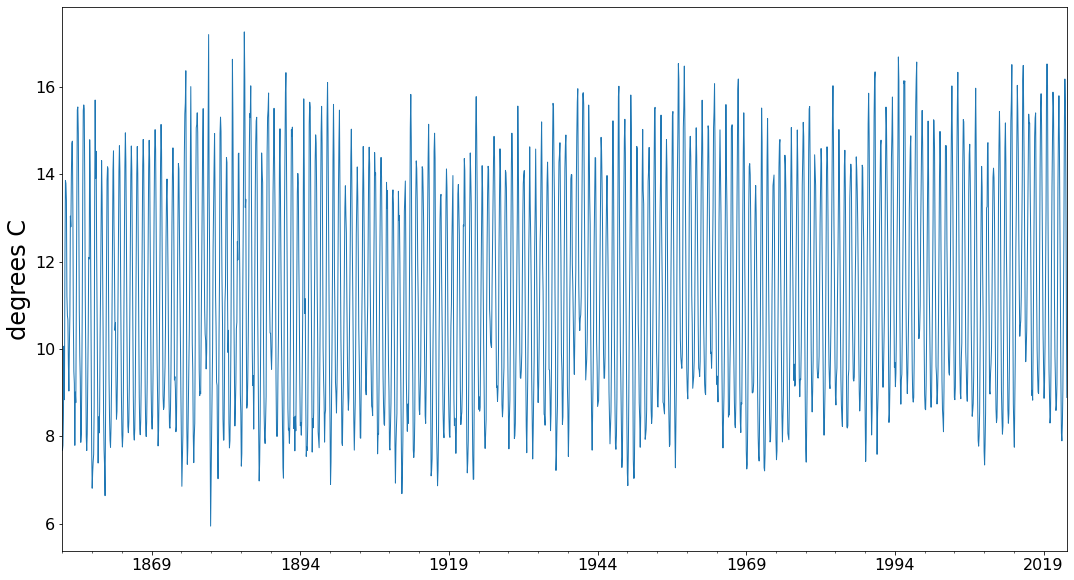

In [13]:
#Simple
#sst.plot(figsize=(18, 10))

#Or slightly nicer 
plt.figure()
ax1 = sst.plot(x='time - sampled monthly',figsize=(18,10),linewidth=1, fontsize=16)
ax1.set_ylabel('degrees C',fontdict={'fontsize':24})

Text(0, 0.5, 'degrees C')

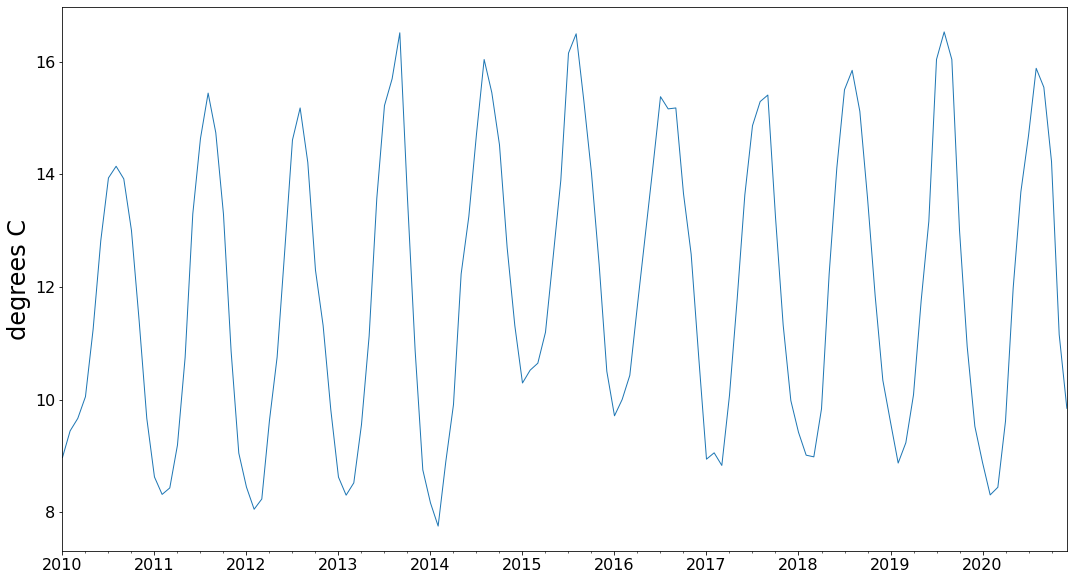

In [14]:
#we can zoom in:
#Or slightly nicer 
plt.figure()
ax1 = sst.loc['2010':'2020'].plot(x='time - sampled monthly',figsize=(18,10),linewidth=1, fontsize=16)
ax1.set_ylabel('degrees C',fontdict={'fontsize':24})

## Part Two - resampling to get ready for spectral analysis

Next we're going to play a bit with spectral analysis, but to do that, we need a 'regularly sampled' time series - this means our montly sampling may not be 'regular' enough to apply some kinds of time series analysis (keep in mind, different months have different numbers of days!). 

To do that, let's use the resample function (so handy):

In [15]:
sst_reg = sst.resample("30D").ffill()

In the code above, we're resampling at 30 Days.  You can read about the resample method [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.resample.html) - it also has several different methods for resampling - which is essentially interpolation. 

Let's take a lookat how that changed out data:

<AxesSubplot:>

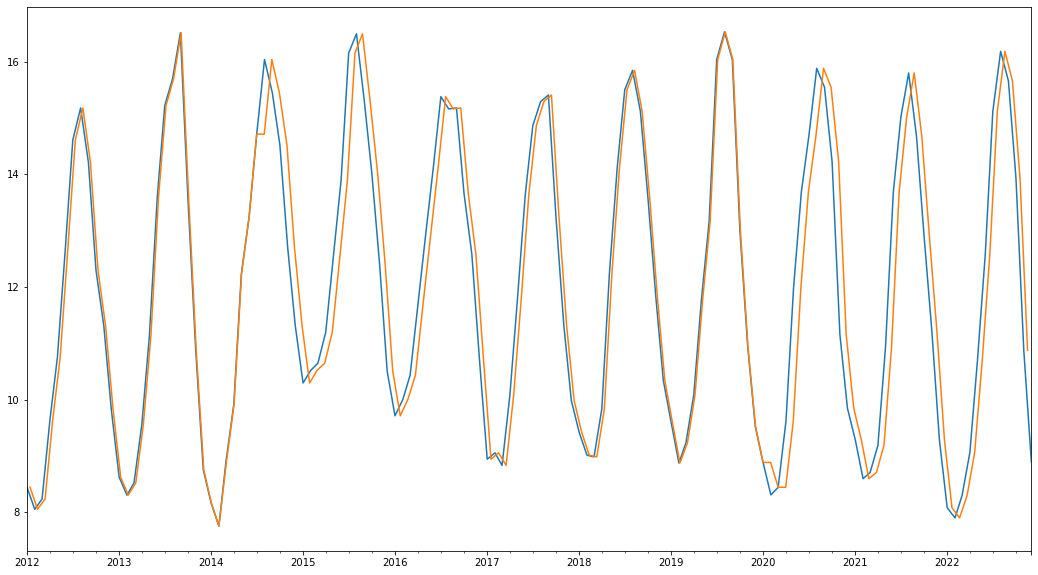

In [16]:
sst.loc['2012':'2022'].plot(figsize=(18, 10))
sst_reg.loc['2012':'2022'].plot()

In [17]:
sst_reg.loc['2020':'2022']

2020-01-01     8.883529
2020-01-31     8.883529
2020-03-01     8.442430
2020-03-31     8.442430
2020-04-30     9.618597
2020-05-30    11.979400
2020-06-29    13.684600
2020-07-29    14.686490
2020-08-28    15.881450
2020-09-27    15.544550
2020-10-27    14.225620
2020-11-26    11.155250
2020-12-26     9.844648
2021-01-25     9.286531
2021-02-24     8.594229
2021-03-26     8.705052
2021-04-25     9.187806
2021-05-25    10.926470
2021-06-24    13.677040
2021-07-24    15.014510
2021-08-23    15.799060
2021-09-22    14.677730
2021-10-22    12.911790
2021-11-21    11.216630
2021-12-21     9.287827
2022-01-20     8.078298
2022-02-19     7.898858
2022-03-21     8.296480
2022-04-20     9.060289
2022-05-20    10.690230
2022-06-19    12.571850
2022-07-19    15.114260
2022-08-18    16.183050
2022-09-17    15.658580
2022-10-17    13.926420
2022-11-16    10.873330
Freq: 30D, dtype: float64

One thing to note from this example - when we resample our data we need to be cautious of how we are changing it!  There are many strategies we could take to deal with the artifacts we have added to our data (i.e. like the one in January 2020!).  Smoothing or using an [interpolation function](https://www.analyticsvidhya.com/blog/2021/06/power-of-interpolation-in-python-to-fill-missing-values/) would likely work well for this. 

### Spctral Analysis and the Fourier Transform

Just by looking at the data - you can see that there is some periodicity in it!  What do you think this is? Consider this question for a minute and jot (in you mental notebook, or in your paper notebook or your jupyter notebook) what do you think is causing the peridicity? 

People who work with time series data a lot like to break signals down into the periodic components that are contributing to the signal. To do that, we use spectral analysis and a tool call the Fourier Transform to characterize what periodic functions have the most "power" in our time series.  Read more about spectral analysis... anywhere on the Web really... here's a good one from [Beyond Data Science](https://towardsdatascience.com/spectral-entropy-an-underestimated-time-series-feature-94e18ae5b958).  

If we want to spectral analysis to our time series, let's use the library `scipy` for the first time (cool). You can read about the [scipy FFT function here](https://realpython.com/python-scipy-fft/) which stands for `Fast Fourier Transform`. This is a way to numerically calculate the Fourier Transform on a discretely sampled dataset. 



Now to apply it.  It's a little complicated, mainly because we're switching between time domain and frequency domain and we need to set up our frequency axix. When we do this correctly, we can clearly see the yearly signal in our data!  Pay attention to comments in the code below:

In [18]:
print(sst.shape[0])
sst.values

2028


array([ 7.682585,  7.798013,  8.468447, ..., 13.92642 , 10.87333 ,
        8.892098])

- First import scipy fft functions and numpy
- Do the FFT... and figure out how to start setting up our frequency array (essentially the y axis):

In [19]:
import scipy
import numpy as np

freq_spec = np.fft.fft(sst_reg.values)
N = sst_reg.shape[0]
n = np.arange(N)

print(N)
freq_spec.shape

2057


(2057,)

In [20]:
# The sample rate is how many samples per time period - 1 sample per 30 days in our case.
# You could do this in terms of days, hours, years, whatever:

#period in between samples
t = 30 #days

#sample rate
sr = 1 / t #samples/days


# Total duration of the dataset in days - 
# You could do this like (number of samples)/(sample rate) OR (number of samples)*(Period between samples)
T = N*t 

# This is a quick way of making an array of frequencies - 
# The largest frequency is frequency that would be sampled only 
freq = np.fft.fftfreq(N,t)
freq.shape


(2057,)

Note - the highest frequency we can sample is called the Nyquest Frequency:
$ \frac{sr}{2} $

Lets check:

In [21]:
print(max(freq))
print(sr/2)

0.016658564252147137
0.016666666666666666


Pretty Close!

Note - the FFT output gives us the frequency spectrum for both the postiive and negative frequencies (don't ask... or ask in a Signal Processing Course!).  Here we'll grab only the positive frequency response:

Text(0, 0.5, 'FFT Amplitude')

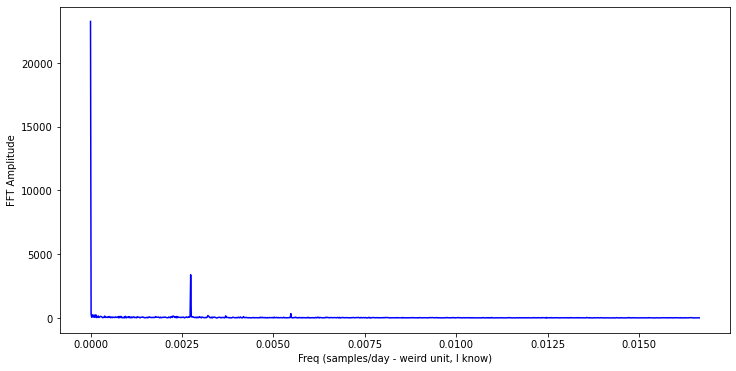

In [22]:

# Get the one-sided specturm
n_oneside = N//2  #the double divide operator is the floor dividor (it dumps the decimals!)

# get the one side frequency and amplitude spectrum
f_oneside = freq[:n_oneside]
f_spec_oneside = np.abs(freq_spec[:n_oneside])

plt.figure(figsize = (12, 6))
plt.plot(f_oneside, f_spec_oneside, 'b')
plt.xlabel('Freq (samples/day - weird unit, I know)')
plt.ylabel('FFT Amplitude')

#Some optional zooms - uncomment to apply:
#plt.ylim((0,500))
#plt.xlim((.0026, .0028))
#plt.xlim((.005, .002))

Great!  Here we see a signal at zero freqency (this is a DC, or non-periodic function... maybe climate change?) and a strong peak at ~ 0.00275 samples/day (this is ABOUT the same as 360 days!).  Whew... glad this worked!!

To make this a little easier to read - lets plot period (time per cycle) on the x axis instead of frequency, and convert it to years...

/var/folders/dr/7qx5y5kj46z_9gs_10d9mxkh0000gn/T/ipykernel_23382/2556024427.py:2: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/f_oneside/365, f_spec_oneside, 'b')


(0.0, 25.0)

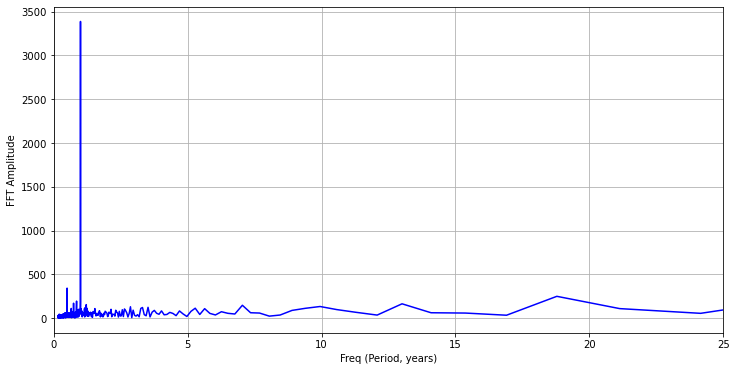

In [23]:
plt.figure(figsize = (12, 6))
plt.plot(1/f_oneside/365, f_spec_oneside, 'b')
plt.xlabel('Freq (Period, years)')
plt.ylabel('FFT Amplitude')
plt.grid()

#I like this zoom:
#plt.ylim((0,500))
plt.xlim((0, 25))

Here we can see peaks at something less than a year, a strong peak at a year - indicating seasonal cycles in SST.  Technically the zero frequency spectral response is for a period of infinity (t = 1/f) - so technically we should make this plot stretch to infinity, but we we are sampling less than a half a cycle for any periods longer than our record length - which is about 170 yeard.  

Do you see the peak at about 7 years - it's subtle but present in our data (It helps to zoom in by adjusting the x-axis to go from 0 to 25 years to see this).  Any idea what that might be?

In [24]:
#Here's the total duration of our record in years
T/365

169.06849315068493